# Recommendation Systems 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from ETL import ETL_class

In [2]:
path_rating = './dataset/ratings/'
path_titles = './dataset/titles/'
etl = ETL_class(path_titles, path_rating)

df_movies = etl.get_movies()
print(df_movies.shape)
df_movies.head(2)

(22998, 15)


,id,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,duration_int,duration_type,listed_in,description
0,as1,s1,movie,the grand seduction,don mckellar,"brendan gleeson, taylor kitsch, gordon pinsent",canada,2021-03-30,2014,g,113 min,113.0,min,"comedy, drama",a small fishing village must procure a local d...
1,as2,s2,movie,take care good night,girish joshi,"mahesh manjrekar, abhay mahajan, sachin khedekar",india,2021-03-30,2018,13+,110 min,110.0,min,"drama, international",a metro family decides to fight a cyber crimin...


In [3]:
df_ratings = etl.get_ratings()[['userId', 'rating', 'movieId']]
print(df_ratings.shape)
df_ratings.head()

(11024165, 3)


,userId,rating,movieId
0,1,1.0,as680
1,1,4.5,ns2186
2,1,5.0,hs2381
3,1,5.0,ns3663
4,1,5.0,as9500


In [4]:
df_ratings.isna().sum()

userId     0
rating     0
movieId    0
dtype: int64

# EDA

In this part we goint to explore data, in the way to find the best movies based on votes and popularity (here we shall define a popularity feature). To measure the votes we use:
$$
W = \frac{R\cdot\nu + C\cdot m}{\nu + m},
$$
where each parameter means:
$$
W = \text{Weight Rating} \\
R = \text{Average for the movie as a number from 0 to 5} \\
\nu = \text{Number of votes for the movie} \\
m = \text{Minimun votes required to be listed in the Top 30\%} \\
C = \text{The mean vote across the whole report}
$$
Thus, let's start by defining this variables

In [7]:
df_W = df_ratings[['movieId', 'rating']]
df_W = df_W.groupby(['movieId']).agg(['mean', 'count', 'sum'])
df_W.rename(columns={'sum': 'popularity'}, inplace=True)
df_W.reset_index(inplace=True)
print(df_W.shape)
df_W.head()

(22998, 4)


movieId    rating                 
               mean count popularity
0     as1  3.467131   502     1740.5
1    as10  3.439571   513     1764.5
2   as100  3.609302   430     1552.0
3  as1000  3.556701   485     1725.0
4  as1001  3.585288   469     1681.5

Here we have defined the popularity as the overall rating sum by movie, which it does make sense, since any movie is watched few times then this movie is not popular.

In [8]:
# creating the variables
R = df_W[df_W.columns[1]]
v = df_W[df_W.columns[2]]
m = df_W[df_W.columns[2]].quantile(0.70)
C = df_W[df_W.columns[1]].mean()

df_W['mean_weight'] = ((R*v) + (C*m)) / (v+m)
print(df_W.shape)
df_W.head()

(22998, 5)


movieId    rating                  mean_weight
               mean count popularity            
0     as1  3.467131   502     1740.5    3.499920
1    as10  3.439571   513     1764.5    3.485478
2   as100  3.609302   430     1552.0    3.568860
3  as1000  3.556701   485     1725.0    3.545000
4  as1001  3.585288   469     1681.5    3.558771

In [9]:
# let's bring in the movie's title
df_merge = df_W.merge(df_movies[['id', 'title']], left_on='movieId', right_on='id').drop(columns=['id'])
old_columns = df_merge.columns
new_columns = ['movieId', 'vote_mean', 'vote_count', 'popularity', 'mean_weight','title']
df_merge.rename(columns={o:n for (o, n) in zip(old_columns, new_columns)}, inplace=True)
df_merge.head()

,movieId,vote_mean,vote_count,popularity,mean_weight,title
0,as1,3.467131,502,1740.5,3.499920,the grand seduction
1,as10,3.439571,513,1764.5,3.485478,david's mother
2,as100,3.609302,430,1552.0,3.568860,wilder napalm
3,as1000,3.556701,485,1725.0,3.545000,sinbad: make me wanna holla
4,as1001,3.585288,469,1681.5,3.558771,simple gifts: the chamber music society at sha...


In [10]:
movie_sorted_ranking = df_merge.sort_values(['mean_weight'], ascending=False)
movie_sorted_ranking.head()

,movieId,vote_mean,vote_count,popularity,mean_weight,title
12422,hs2172,3.717143,525,1951.5,3.628366,the man who killed hitler and then the bigfoot
9586,as9627,3.724512,461,1717.0,3.625967,thalaivii (telugu)
16638,ns3200,3.709278,485,1799.0,3.620820,space jungle
11128,hs1007,3.703061,490,1814.5,3.618165,the haunting in connecticut
12510,hs2251,3.702648,491,1818.0,3.618045,masterchef junior


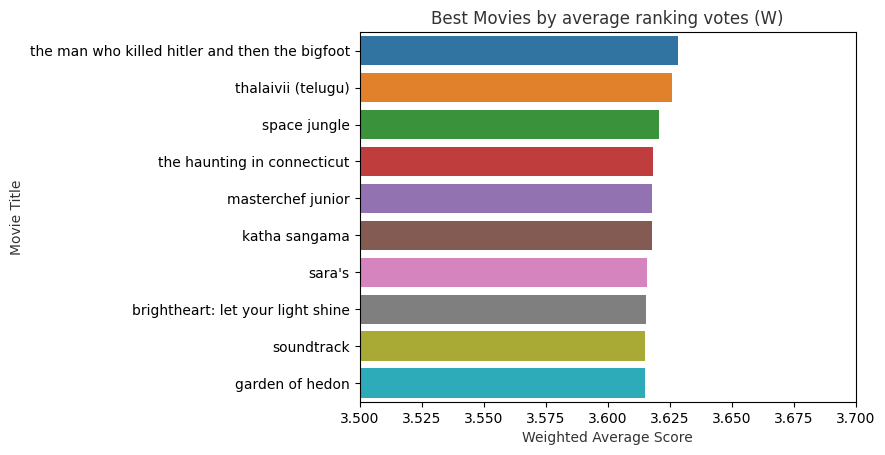

In [11]:
plt.figure()
ax = sns.barplot(x='mean_weight', y='title', data=movie_sorted_ranking.head(10))
plt.xlim(3.5,3.7)
plt.title('Best Movies by average ranking votes (W)', alpha=0.8)
plt.xlabel('Weighted Average Score', alpha=0.8)
plt.ylabel('Movie Title', alpha=0.8)
plt.show()

Here we find 'the man who killed hitler...' is in general de movie most popular based on the average weighted metric. Following by thalaivii, space jungle, etc.

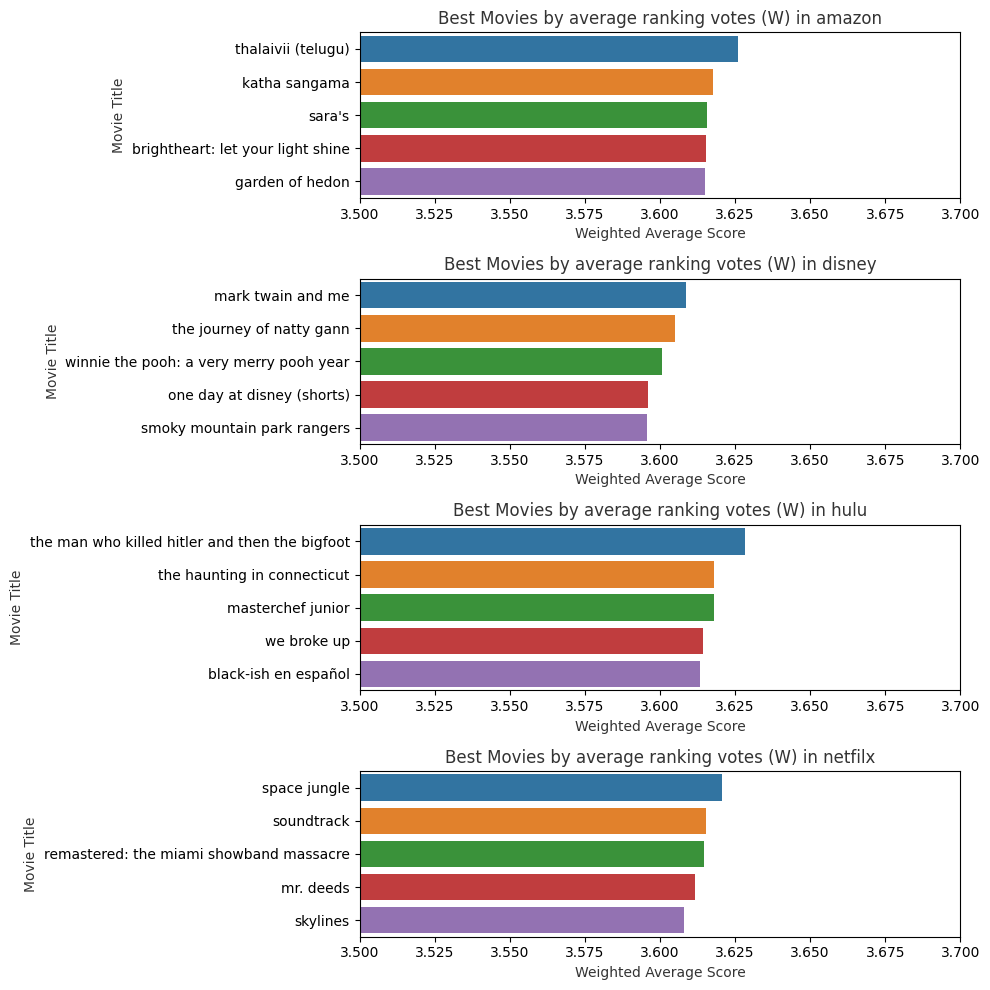

In [17]:
# let's see the best movies by platform
plt.figure(figsize=(10,10))
platform = ['amazon', 'disney', 'hulu', 'netfilx']
for ii, m in enumerate(platform):
    plt.subplot(4,1,ii+1)
    begins = m[0]
    df_platform = movie_sorted_ranking.loc[movie_sorted_ranking.movieId.str.contains('^{}'.format(begins))].head()
    ax = sns.barplot(x='mean_weight', y='title', data=df_platform)
    plt.xlim(3.5,3.7)
    plt.title('Best Movies by average ranking votes (W) in '+str(m), alpha=0.8)
    plt.xlabel('Weighted Average Score', alpha=0.8)
    plt.ylabel('Movie Title', alpha=0.8)
plt.tight_layout()
plt.show()

So it's in the previous figure we see where come the best titles from.<br>
And what about votes based on popularity? let'see

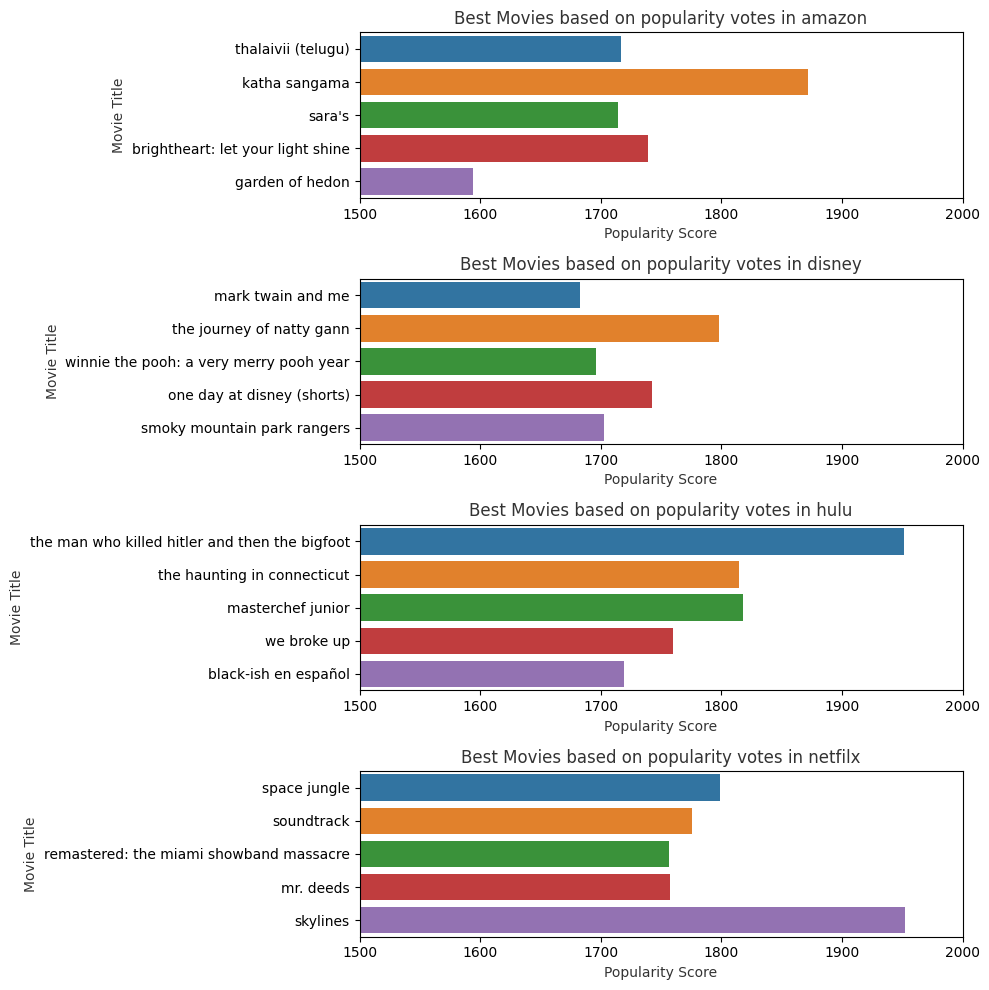

In [21]:
plt.figure(figsize=(10,10))
platform = ['amazon', 'disney', 'hulu', 'netfilx']
for ii, m in enumerate(platform):
    plt.subplot(4,1,ii+1)
    begins = m[0]
    df_platform = movie_sorted_ranking.loc[movie_sorted_ranking.movieId.str.contains('^{}'.format(begins))].head()
    ax = sns.barplot(x='popularity', y='title', data=df_platform)
    plt.xlim(1500,2000)
    plt.title('Best Movies based on popularity votes in '+str(m), alpha=0.8)
    plt.xlabel('Popularity Score', alpha=0.8)
    plt.ylabel('Movie Title', alpha=0.8)
plt.tight_layout()
plt.show()

Now based on popularity we can apreciate the variance is higher than average-weight votes based variance. However, there's a important correlation between this to 'metrics'.